<a href="https://colab.research.google.com/github/Hashan1999/Pig-Weight-Estimation/blob/main/Mask%20with%20SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

In [2]:
import zipfile, os

In [3]:
img_dir = "/content/drive/MyDrive/real_pigs"
print("Real pig images:", os.listdir(img_dir)[:10])

Real pig images: ['7.jpeg', '6.jpeg', '13.png', '11.png', '8.jpeg', '4.jpeg', '5.jpeg', '1.jpeg', '10.jpeg', '2.jpeg']


In [4]:
!pip install opencv-python matplotlib --quiet
!git clone https://github.com/facebookresearch/segment-anything.git
%cd segment-anything
!pip install -e . --quiet
%cd /content


Cloning into 'segment-anything'...
remote: Enumerating objects: 304, done.
remote: Total 304 (delta 0), reused 0 (delta 0), pack-reused 304 (from 1)
Receiving objects: 100% (304/304), 18.31 MiB | 22.89 MiB/s, done.
Resolving deltas: 100% (161/161), done.
/content/segment-anything
  Preparing metadata (setup.py) ... done
/content


In [5]:
!wget -O sam_vit_b.pth "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"


--2025-12-10 10:16:48--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.173.40, 18.155.173.80, 18.155.173.79, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.173.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’

sam_vit_b.pth       100%[===================>] 357.67M   119MB/s    in 3.0s    

2025-12-10 10:16:52 (119 MB/s) - ‘sam_vit_b.pth’ saved [375042383/375042383]



In [7]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('/content/segment-anything')
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

sam_checkpoint = "sam_vit_b.pth"
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam.to(device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.92,
    crop_n_layers=1,
)


Device: cuda


In [8]:
def get_best_sam_mask(image_bgr):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image_rgb)

    if len(masks) == 0:
        return None

    H, W = image_rgb.shape[:2]
    max_area = 0
    best_mask = None

    for m in masks:
        area = m["area"]
        # Skip nearly full-image masks (usually background)
        if area > 0.85 * H * W:
            continue
        if area > max_area:
            max_area = area
            best_mask = m["segmentation"]

    return best_mask


In [10]:
mask_out_dir = "/content/real_pig_masks"
os.makedirs(mask_out_dir, exist_ok=True)

# Define a maximum image dimension to prevent OOM errors
MAX_DIM = 1024

for fname in os.listdir(img_dir):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img_path = os.path.join(img_dir, fname)
    img = cv2.imread(img_path)
    if img is None:
        print("Failed to read:", img_path)
        continue

    # Resize image if too large to prevent OOM
    h, w, _ = img.shape
    if max(h, w) > MAX_DIM:
        scale = MAX_DIM / max(h, w)
        img = cv2.resize(img, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
        print(f"Resized {fname} from ({w}, {h}) to ({img.shape[1]}, {img.shape[0]})")

    best_mask = get_best_sam_mask(img)
    if best_mask is None:
        print("No good SAM mask for:", fname)
        continue

    mask_uint8 = (best_mask.astype(np.uint8)) * 255

    mask_name = os.path.splitext(fname)[0] + "_mask.png"
    mask_path = os.path.join(mask_out_dir, mask_name)
    cv2.imwrite(mask_path, mask_uint8)

    print("Saved SAM mask:", mask_path)


Resized 7.jpeg from (6720, 4480) to (1024, 682)
Saved SAM mask: /content/real_pig_masks/7_mask.png
Saved SAM mask: /content/real_pig_masks/6_mask.png
Saved SAM mask: /content/real_pig_masks/13_mask.png
Resized 11.png from (4500, 3000) to (1024, 682)
Saved SAM mask: /content/real_pig_masks/11_mask.png
Saved SAM mask: /content/real_pig_masks/8_mask.png
Resized 4.jpeg from (6431, 4032) to (1024, 642)
Saved SAM mask: /content/real_pig_masks/4_mask.png
Resized 5.jpeg from (6720, 4480) to (1024, 682)
Saved SAM mask: /content/real_pig_masks/5_mask.png
Resized 1.jpeg from (6834, 4213) to (1024, 631)
Saved SAM mask: /content/real_pig_masks/1_mask.png
Resized 10.jpeg from (7263, 4012) to (1023, 565)
Saved SAM mask: /content/real_pig_masks/10_mask.png
Resized 2.jpeg from (4255, 2068) to (1024, 497)
Saved SAM mask: /content/real_pig_masks/2_mask.png
Resized 12.png from (5632, 3072) to (1024, 558)
Saved SAM mask: /content/real_pig_masks/12_mask.png
Resized 9.jpeg from (5000, 3348) to (1024, 685)
Sa

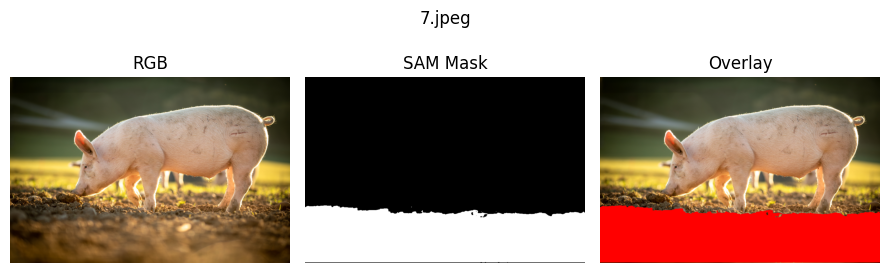

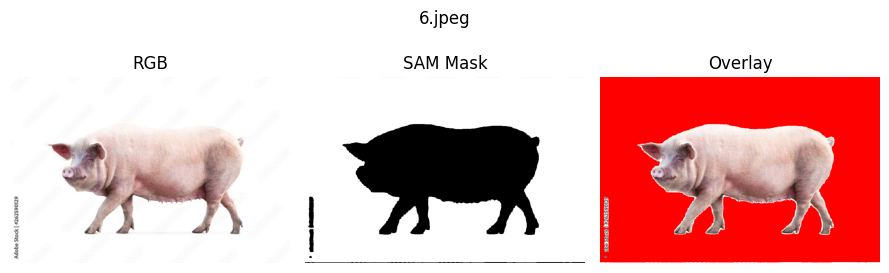

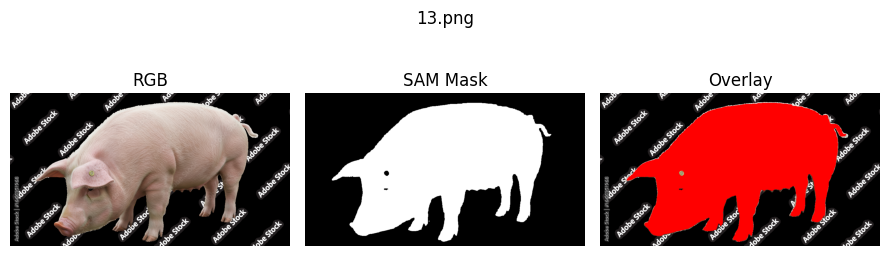

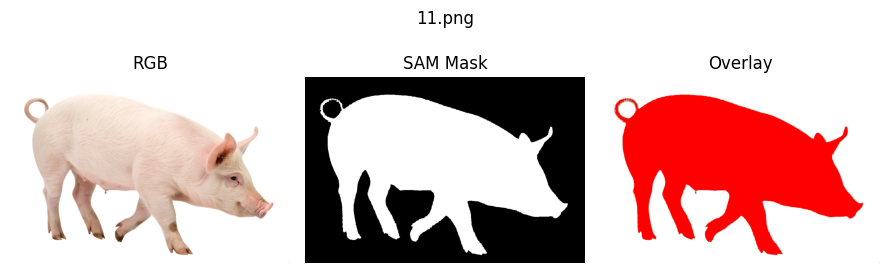

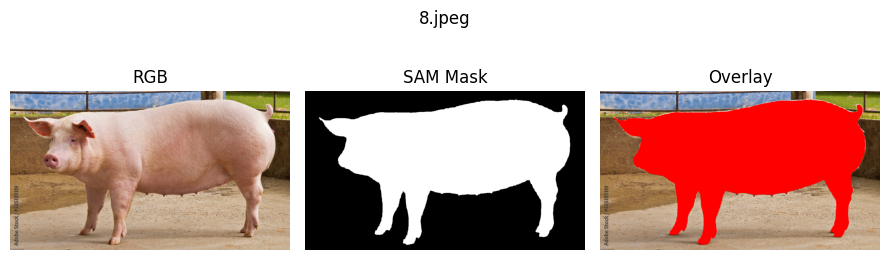

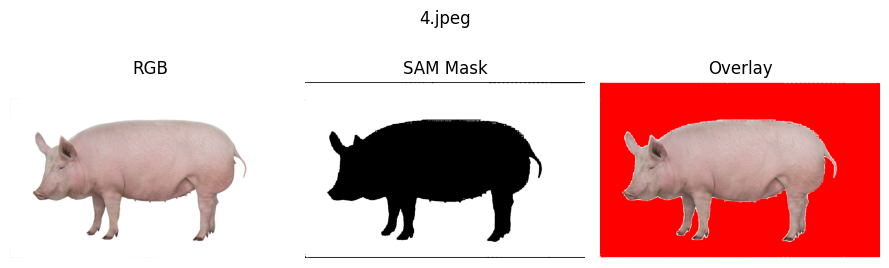

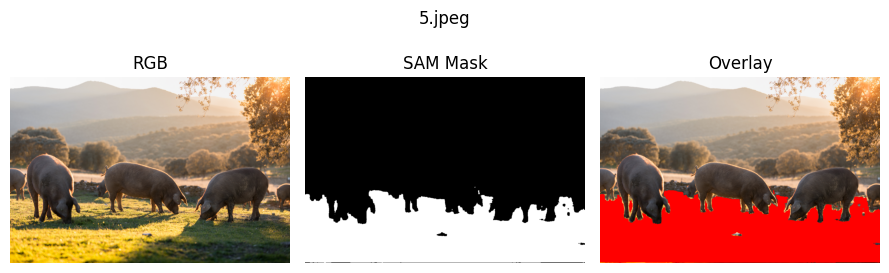

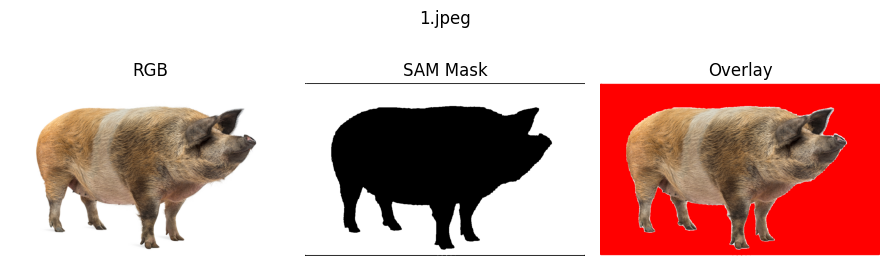

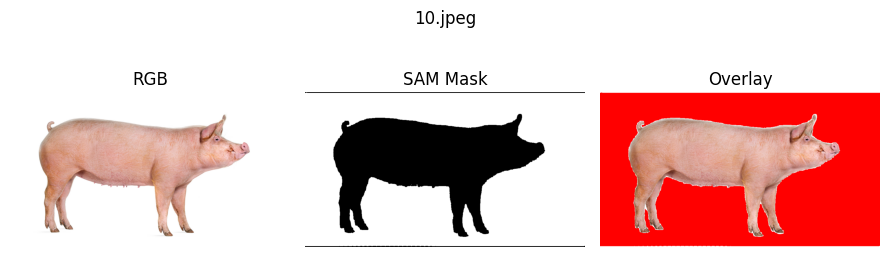

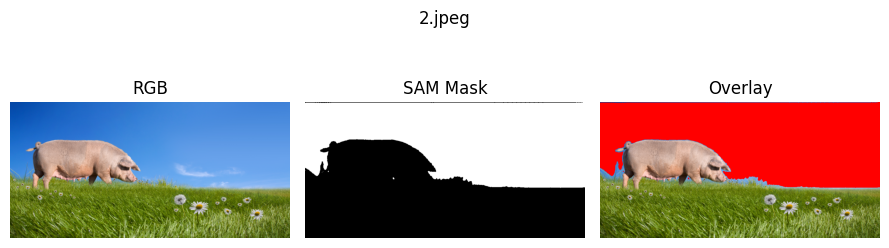

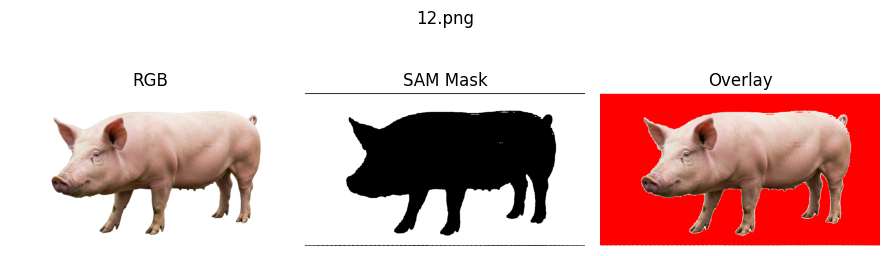

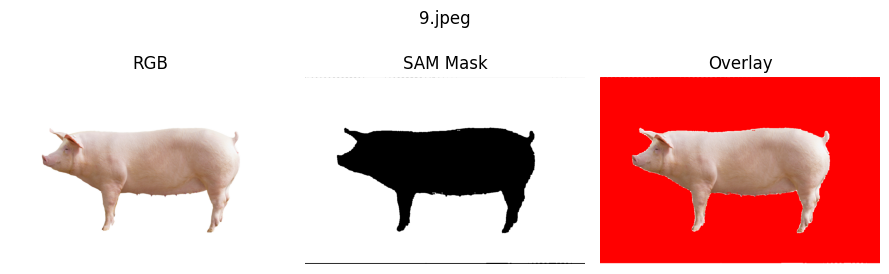

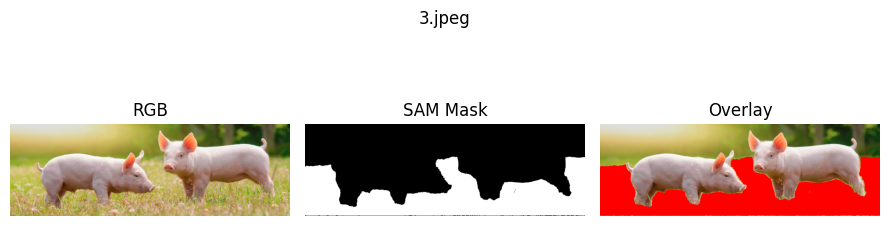

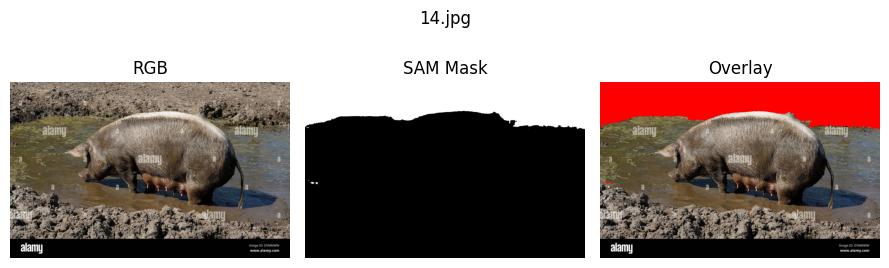

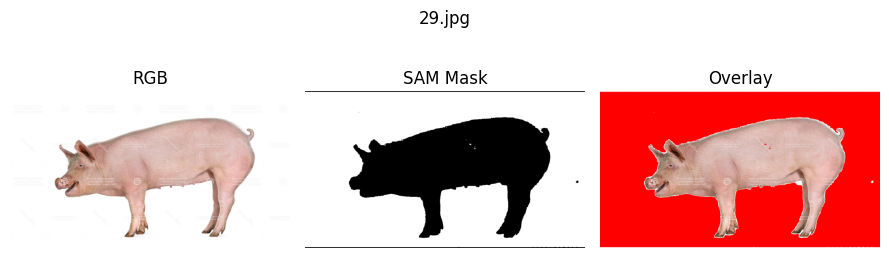

In [13]:
sample_files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))][:15]

for fname in sample_files:
    img = cv2.imread(os.path.join(img_dir, fname))

    mask_name = os.path.splitext(fname)[0] + "_mask.png"
    mask_path = os.path.join(mask_out_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print("No mask for", fname)
        continue

    # Resize img to match the mask dimensions
    img_resized = cv2.resize(img, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_AREA)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    overlay = img_rgb.copy()
    overlay[mask > 0] = [255, 0, 0]

    plt.figure(figsize=(9,3))
    plt.suptitle(fname)
    plt.subplot(1,3,1); plt.title("RGB"); plt.imshow(img_rgb); plt.axis("off")
    plt.subplot(1,3,2); plt.title("SAM Mask"); plt.imshow(mask, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
    plt.tight_layout()
    plt.show()
